#**Casting the Net:  Machine Learning for Phishing Website Detection**

##Abstract 

The goal of the project was to train a series of models to classify URLs as legimitimate or fraudulent (URLs that lead to phishing scams) and provide insights into the classification process. Decision Trees, Random Forests, and Neural networks were used as models while feature importances provided understanding as to how the model classifies samples. The Decision Tree and Random Forest models performed well with accuracies between 95% and 100%; The Neural Network implementation did not perform as well with accuracies maxing out at around 76%. Feature importance analysis revealed that certain features and feature categories played far more important roles in classifiying the URLs. Specifically, the structure of the filename and its associated directory in the URL as well as the information pertaining to the website, namely the hostname TTL, number of redirects, the time it took for the domain to be activated, etc.

##Introduction

Here you have to explain the problem that you are solving. Explain why it is important, and what are the main challenges. Mention previous attempts (add papers as references) to solve it. Mainly focus on the techniques closely related to our approach. Briefly describe your approach and explain why it is promising for solving the addressed problem. Mention the dataset and the main results achieved.

Phishing is a common source of fraud on the internet that can have
devastating effects on the lives of its victims. The goal of this project is to
produce a model that can quickly identify whether or not a URL presented to a
user is malicious as well as provide an intuitive understanding as to why the
URL in question is malicious (or not) by extracting insights from the model by examining feature importance (only performed on decision tree and random forest models in this report).  The dataset used is composed of **88,647**
training examples with **111 features** in total (the features are categorised into
implicit groups that correspond to specific parts of a URLs anatomy such as
the domain or protocol) [1]. 

This dataset is used to train a Decision Tree, Random Forest, and Neural Network to classify the URLs. Feature importance is then extracted from the Decision Tree and Random Forest models to provide insight into the importance of the datasets features in regards to classfication.

 The majority of existing attempts at phishing detection rely upon a mix of URL features as well as the content of the webpage(s) the URL redirects too, and often take a "big data" approach in regards to the dataset used; Specifically, the datasets are continuously supplemented via web scraping and similar techniques. One of the more interesting approaches supplemented the typical practice of URL feature extraction with a scoring system based on the URL search engine page rank as phishing websites often rank very low (versus the website it is trying to impersonate) [2]. Another interesting appraoch was taken by Google researchers were they used a combination of URL feature extraction, webpage content, whitelists and blacklists, and hosting details to inform their models [3].








##**Experimental Setup**

https://data.mendeley.com/datasets/72ptz43s9v/1

Total number of instances: 88,647 \\
Number of legitimate website instances (labeled as 0): 58,000 \\
Number of phishing website instances (labeled as 1): 30,647 \\
Total number of features: 111 \\

train size = 62052 samples (70% of dataset) \\
test size = 26595 samples (30% of the dataset)

**why use a imbalanced dataset?**

Due to the fact that most websites are legitimate rather than fraudulent, the imbalance reflects the reality of the problem space. While the code below can be configured to use a balanced or imbalanced dataset, the model performs better when the imbalanced dataset is used. 

**Models and Hyperparameters**

Decision Tree implemented with Sklearn

Random Forest implemented with Sklearn 

Neural Network (implemented with PyTorch) with the following parameters: 

* **learning rate**: 0.01

* **weight decay**: 0.00005 

* **momentum**: 0.87

* **batch size**: 64

##**Methodology**

1. process the data by separating the label column of the CSV file from the rest of the feature columns. 

2. Split the training data into training, validation, and test sets 

3. create Tensor copies of the aformentioned sets for use with the pytorch Neural Network. 

4. Train the Decision Tree and Random Forests and calculate their respective accuracies

5. Extract feature importances based on Mean Decrease in Impurity (MDI) and feature permutation for both the Decision Tree and Random Forest

6. Train Neural Network and calculate accuracy



##**Experimental Results**

In [201]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import sklearn.ensemble
import sklearn.inspection
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

##Data Processing

In [221]:
#download of dataset
!gdown 14Jx_k3qAdzEr7-O2Urg_IESw9UA07nEP

#dataset = pd.read_csv('dataset_full.csv')

#feature labels and number of features for later use
feature_names = list(dataset.columns.values)[:111]
num_features = len(feature_names)

#split the csv into training data and labels
X, y = dataset.iloc[:,0:111], dataset['phishing']

#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#creation of validation sets for use with feature permutation from the training sets
X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, test_size=0.2)

#Conversion to PyTorch Tensors for use with the Neural Network implementation 
X_train_torch = torch.Tensor(X_train.values)
y_train_torch = torch.Tensor(y_train.values).long()

X_test_torch = torch.Tensor(X_test.values)
y_test_torch = torch.Tensor(y_test.values).long()

Downloading...
From: https://drive.google.com/uc?id=14Jx_k3qAdzEr7-O2Urg_IESw9UA07nEP
To: /content/dataset_full.csv
100% 25.1M/25.1M [00:00<00:00, 263MB/s]


##**Decision Tree Implementation**

In [224]:
"""The code in laboratory 9 was used as the starting point for the code below here (as a means to understand Decision Trees and Random Forest implementations. Further adjustements were 
a process of trial and error based on personal research"""

#train the model
tree = sklearn.tree.DecisionTreeClassifier(random_state=0).fit(X_train, y_train);

#training predictions and accuracy
y_pred = tree.predict(X_train)

training_accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

#test predictions and accuracy
y_pred = tree.predict(X_test)

test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('{:.2%} training accuracy'.format(training_accuracy))
print('{:.2%} training error'.format(1-training_accuracy))
print('{:.2%} test accuracy'.format(test_accuracy))
print('{:.2%} test error'.format(1-test_accuracy))

#for plotting purposes
tree_acc = [training_accuracy*100, test_accuracy*100]

99.99% training accuracy
0.01% training error
95.31% test accuracy
4.69% test error


##Feature Importances

#####What is **Mean Decrease in Impurity**?

A "decrease in impurity" refers to the degree to which a feature contributes to the reduction of overall impurity in decision tree and random forest algorithms, and more braodly, to the importance of each feature in predicting the target variable.

The MDI values are calculated based on the difference between the impurity of the parent node and the weighted average impurity of the resulting child nodes

#####What is **Feature Permutation**?

Feature importance is calculated by randomly permuting the values of each feature in the dataset, and observing the resulting decrease in model accuracy.

If a feature is important for the model's predictions, then permuting the values of that feature will negatively affect the performance of the model and vice versa.

In this case, the permutation process is repeated 10 times, and the resulting values represent mean decreases in accuracy. 




###Mean Decrease In Impurity (MDI)

In [204]:
#extract the feature importances (MDI values) from the Decision Tree model object
importances = tree.feature_importances_
tree_importances = pd.Series(importances, index=feature_names)

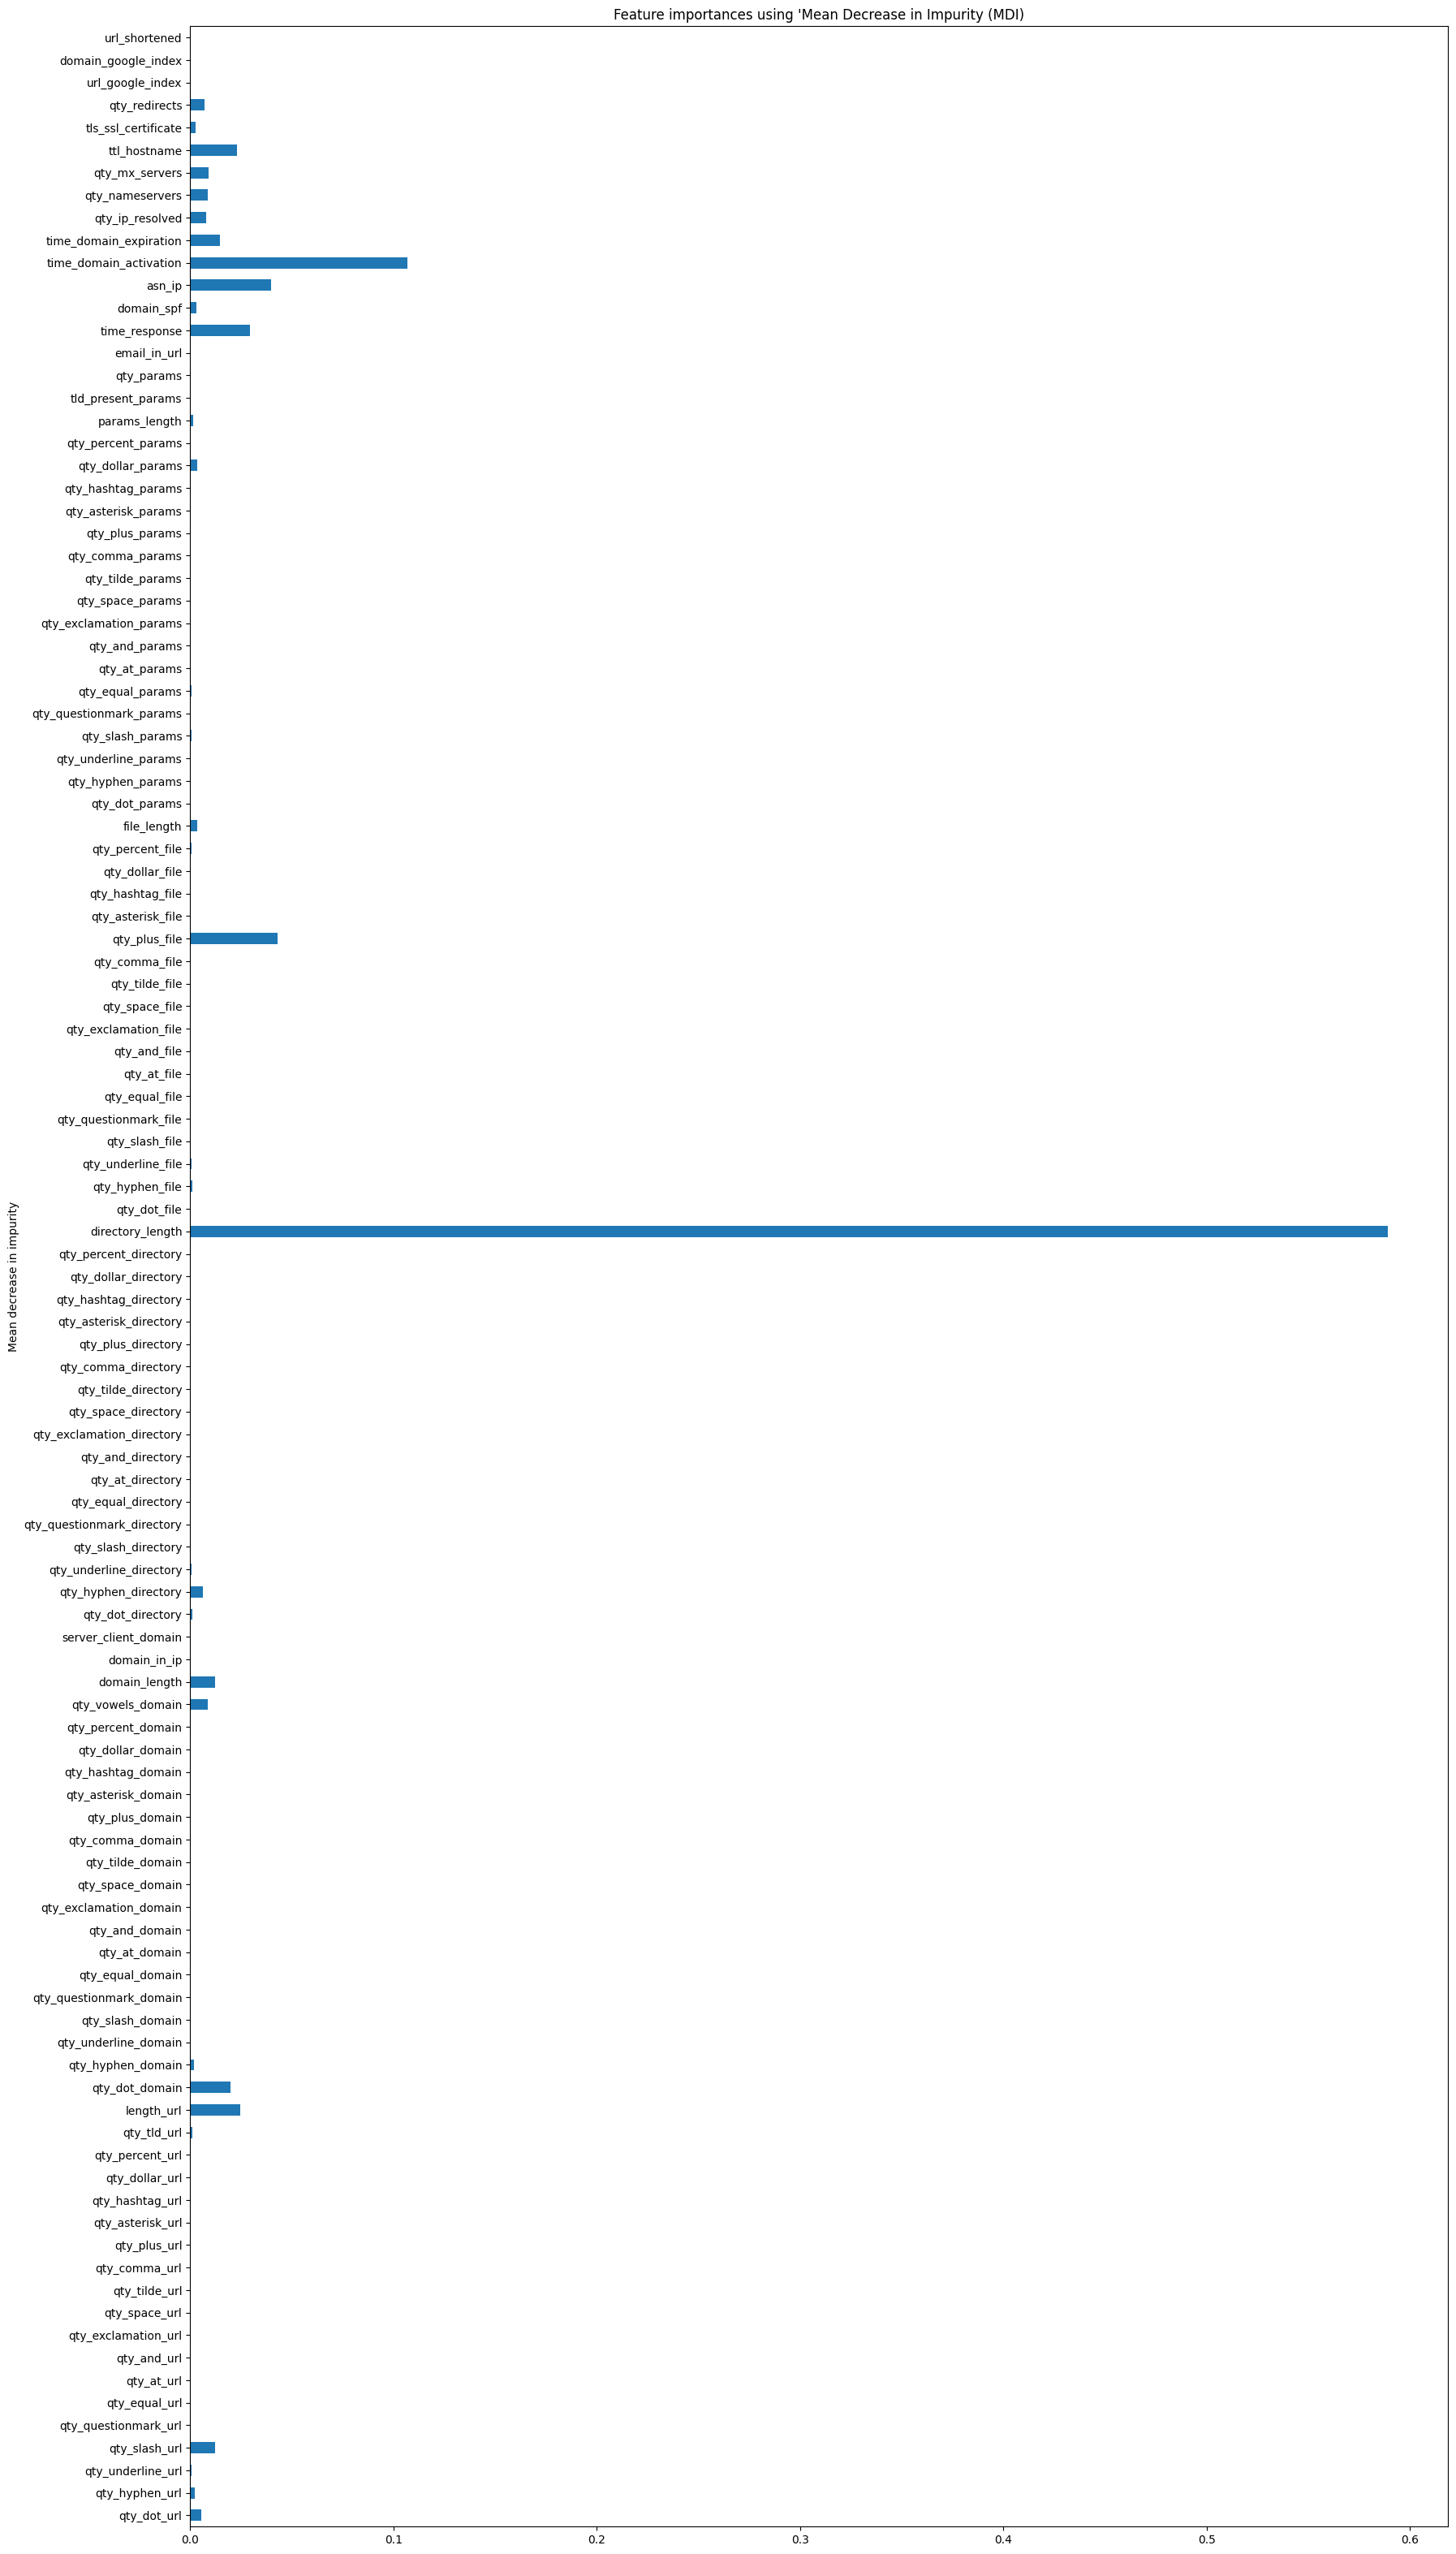

In [205]:
#plot the values with associated feature names
fig, ax = plt.subplots()
fig.set_size_inches(20,40)
tree_importances.plot.barh(ax=ax, align='center')

#uncomment line below for sorted values
#tree_importances.sort_values().plot.barh(ax=ax, align='center')

plt.title("Feature importances using 'Mean Decrease in Impurity (MDI)")
plt.ylabel("Mean decrease in impurity");

###Feature Permutation



In [206]:
#feature importance mean calculation based on 10 runs (n_repeats)
result = permutation_importance(tree, X_vali, y_vali, n_repeats=10, random_state=42, n_jobs=-1)
#mean of the feature importances (mean decrease in accuracy) over the 10 runs
importances = result.importances_mean

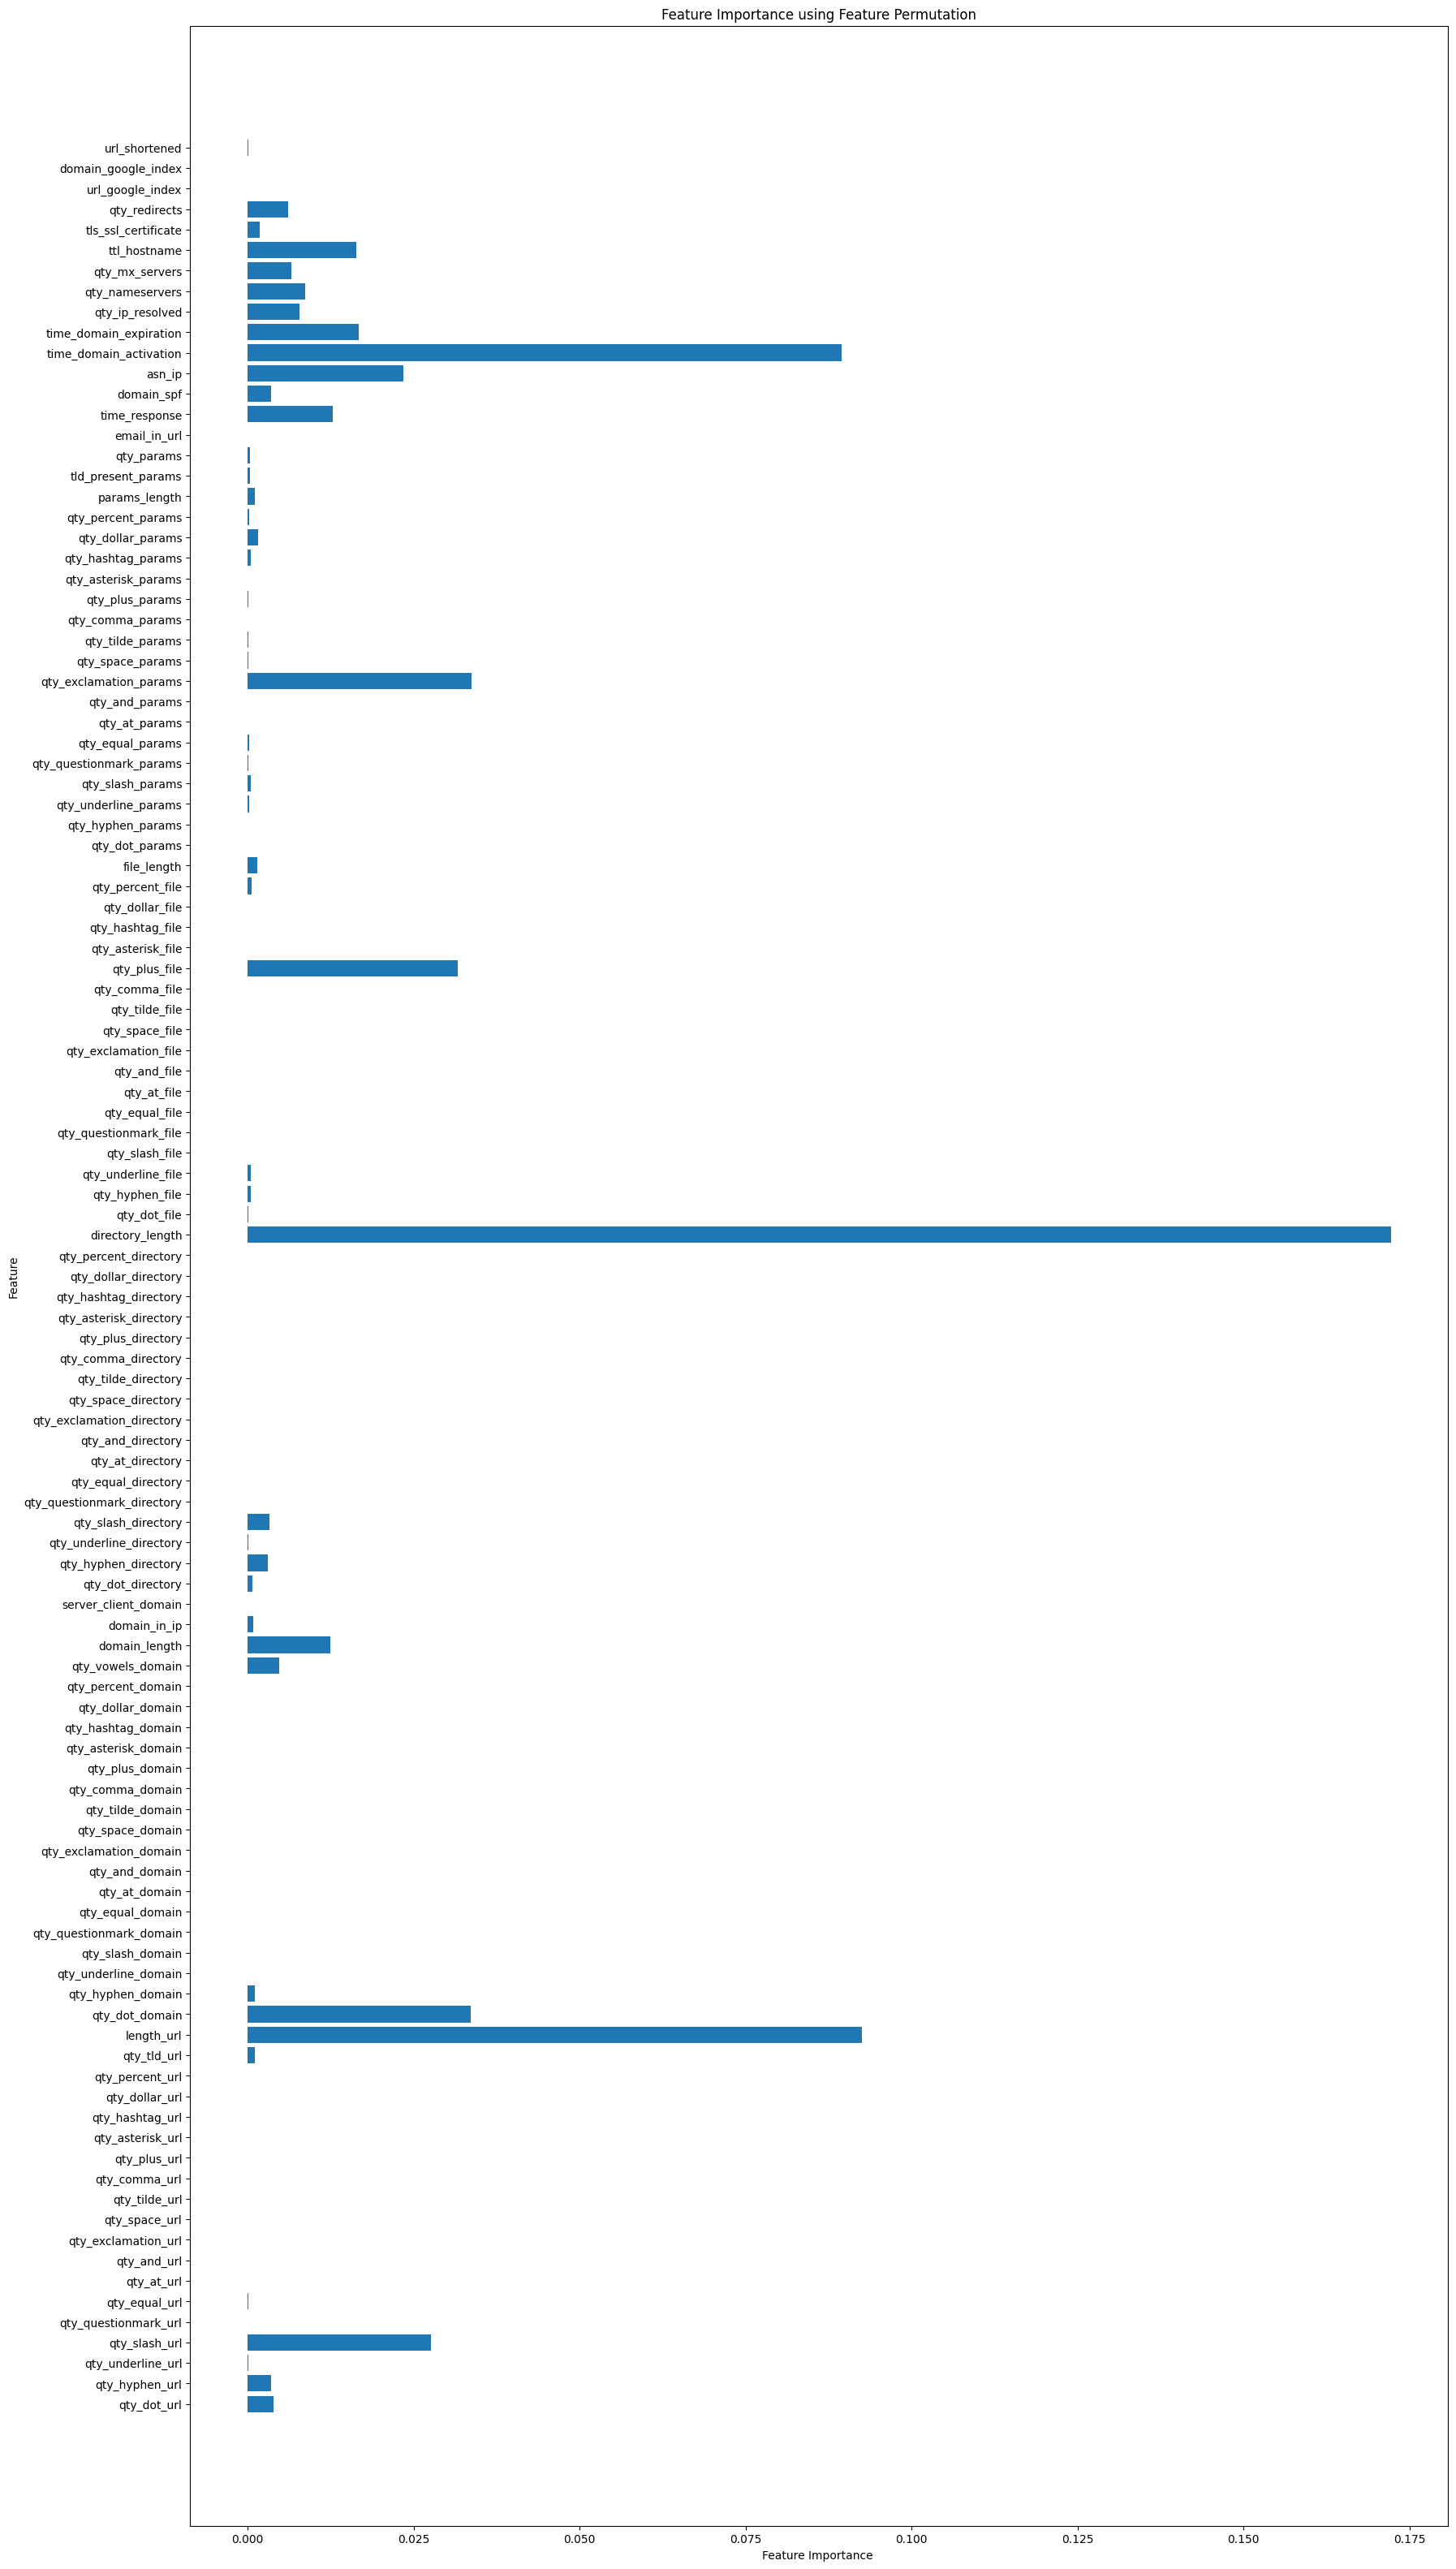

In [207]:
#plotting of the feature importances with associated labels
plt.figure(figsize=(20,40))
plt.barh(range(X.shape[1]), importances, align='center')
plt.yticks(range(X.shape[1]), feature_names)
plt.title('Feature Importance using Feature Permutation')
plt.xlabel('Feature Importance ')
plt.ylabel('Feature')
plt.show()

##**Random Forest Implementation**


In [208]:
"""The code in laboratory 9 was used as the starting point for the code below here (as a means to understand Decision Trees and Random Forest implementations. Further adjustements were 
a process of trial and error based on personal research"""

#train the model
forest = sklearn.ensemble.RandomForestClassifier(random_state=0).fit(X_train, y_train);

#training predictions and accuracy
y_pred = forest.predict(X_train)

training_accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

#test predictions and accuracy
y_pred = forest.predict(X_test)

test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('{:.2%} training accuracy'.format(training_accuracy))
print('{:.2%} training error'.format(1-training_accuracy))
print('{:.2%} test accuracy'.format(test_accuracy))
print('{:.2%} test error'.format(1-test_accuracy))

#for plotting purposes
forest_acc = [training_accuracy*100, test_accuracy*100]

100.00% training accuracy
0.00% training error
97.09% test accuracy
2.91% test error


##Feature Importances

###Mean Decrease in Impurity (MDI)


In [209]:
#extract the feature importances (MDI values) from the Random Forest model object
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

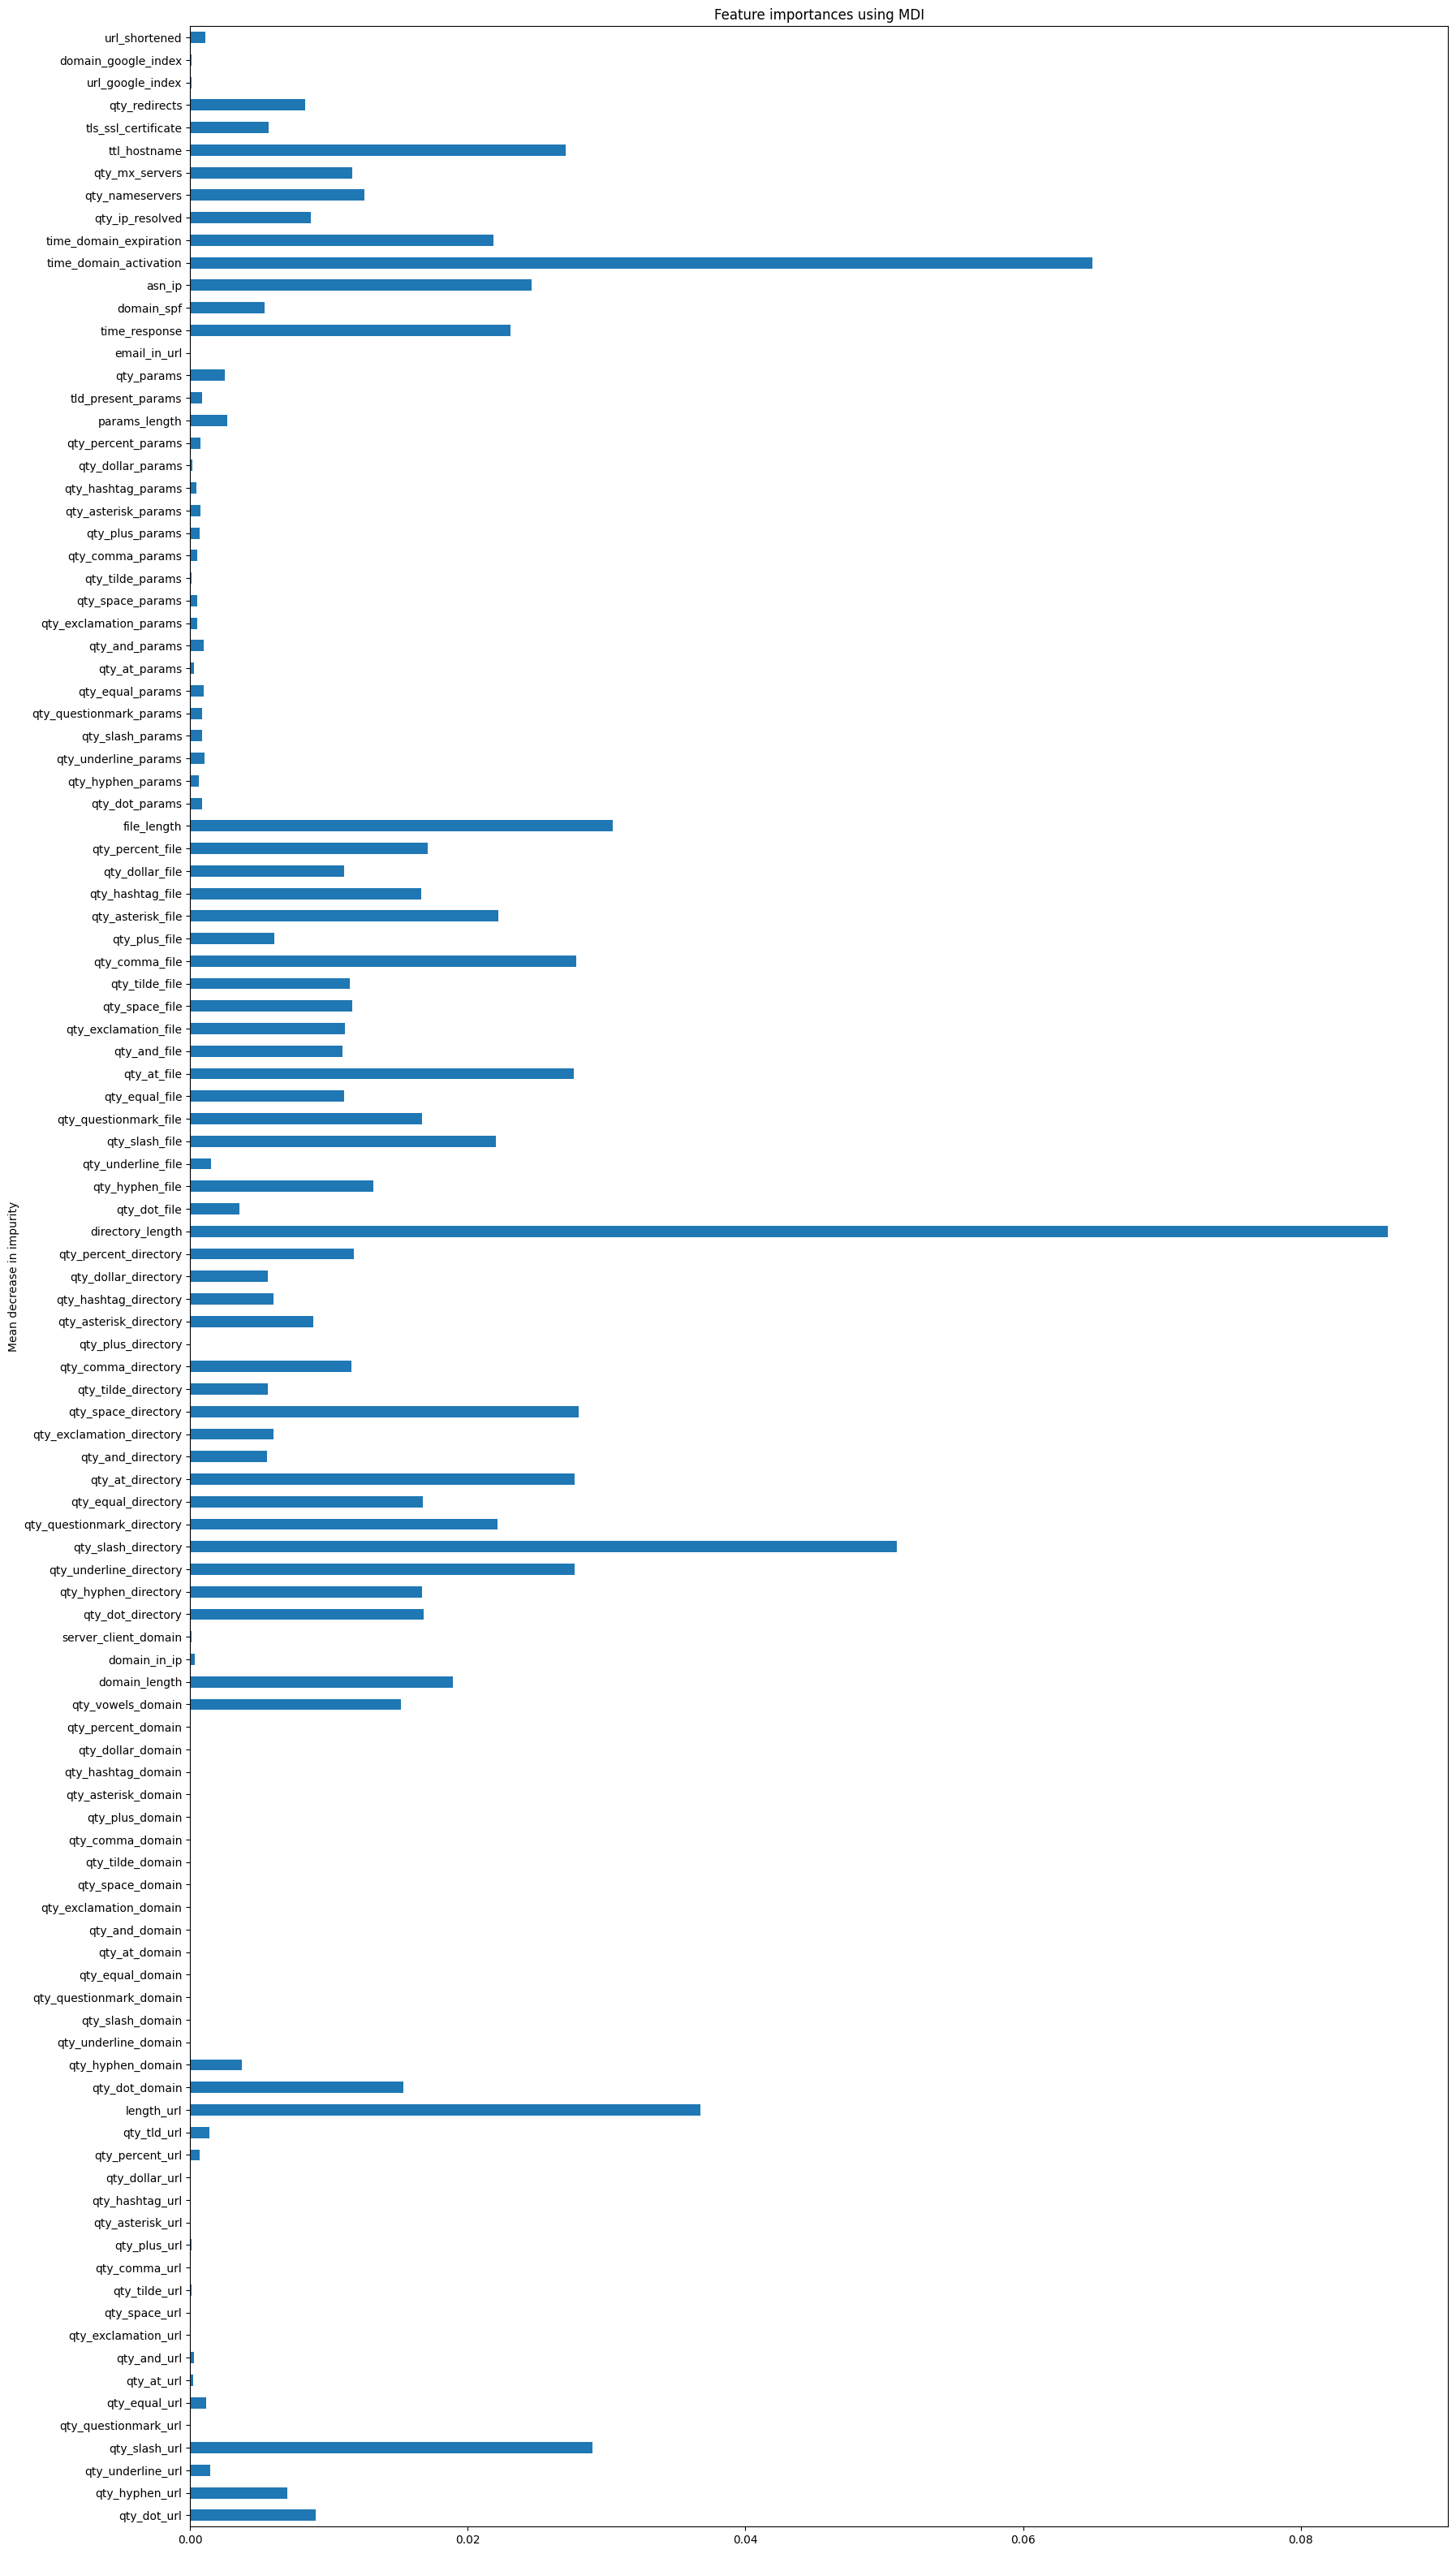

In [210]:
#plot the values with associated feature names
fig, ax = plt.subplots()
fig.set_size_inches(20,40)
forest_importances.plot.barh(ax=ax, align='center')

#uncomment line below for sorted values
#forest_importances.sort_values().plot.barh(ax=ax, align='center')

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity");

###Feature Permutation

In [211]:
#feature importance mean calculation based on 10 runs (n_repeats)
result = permutation_importance(forest, X_vali, y_vali, n_repeats=10, random_state=42, n_jobs=-1)
#mean of the feature importances over the 10 runs
importances = result.importances_mean

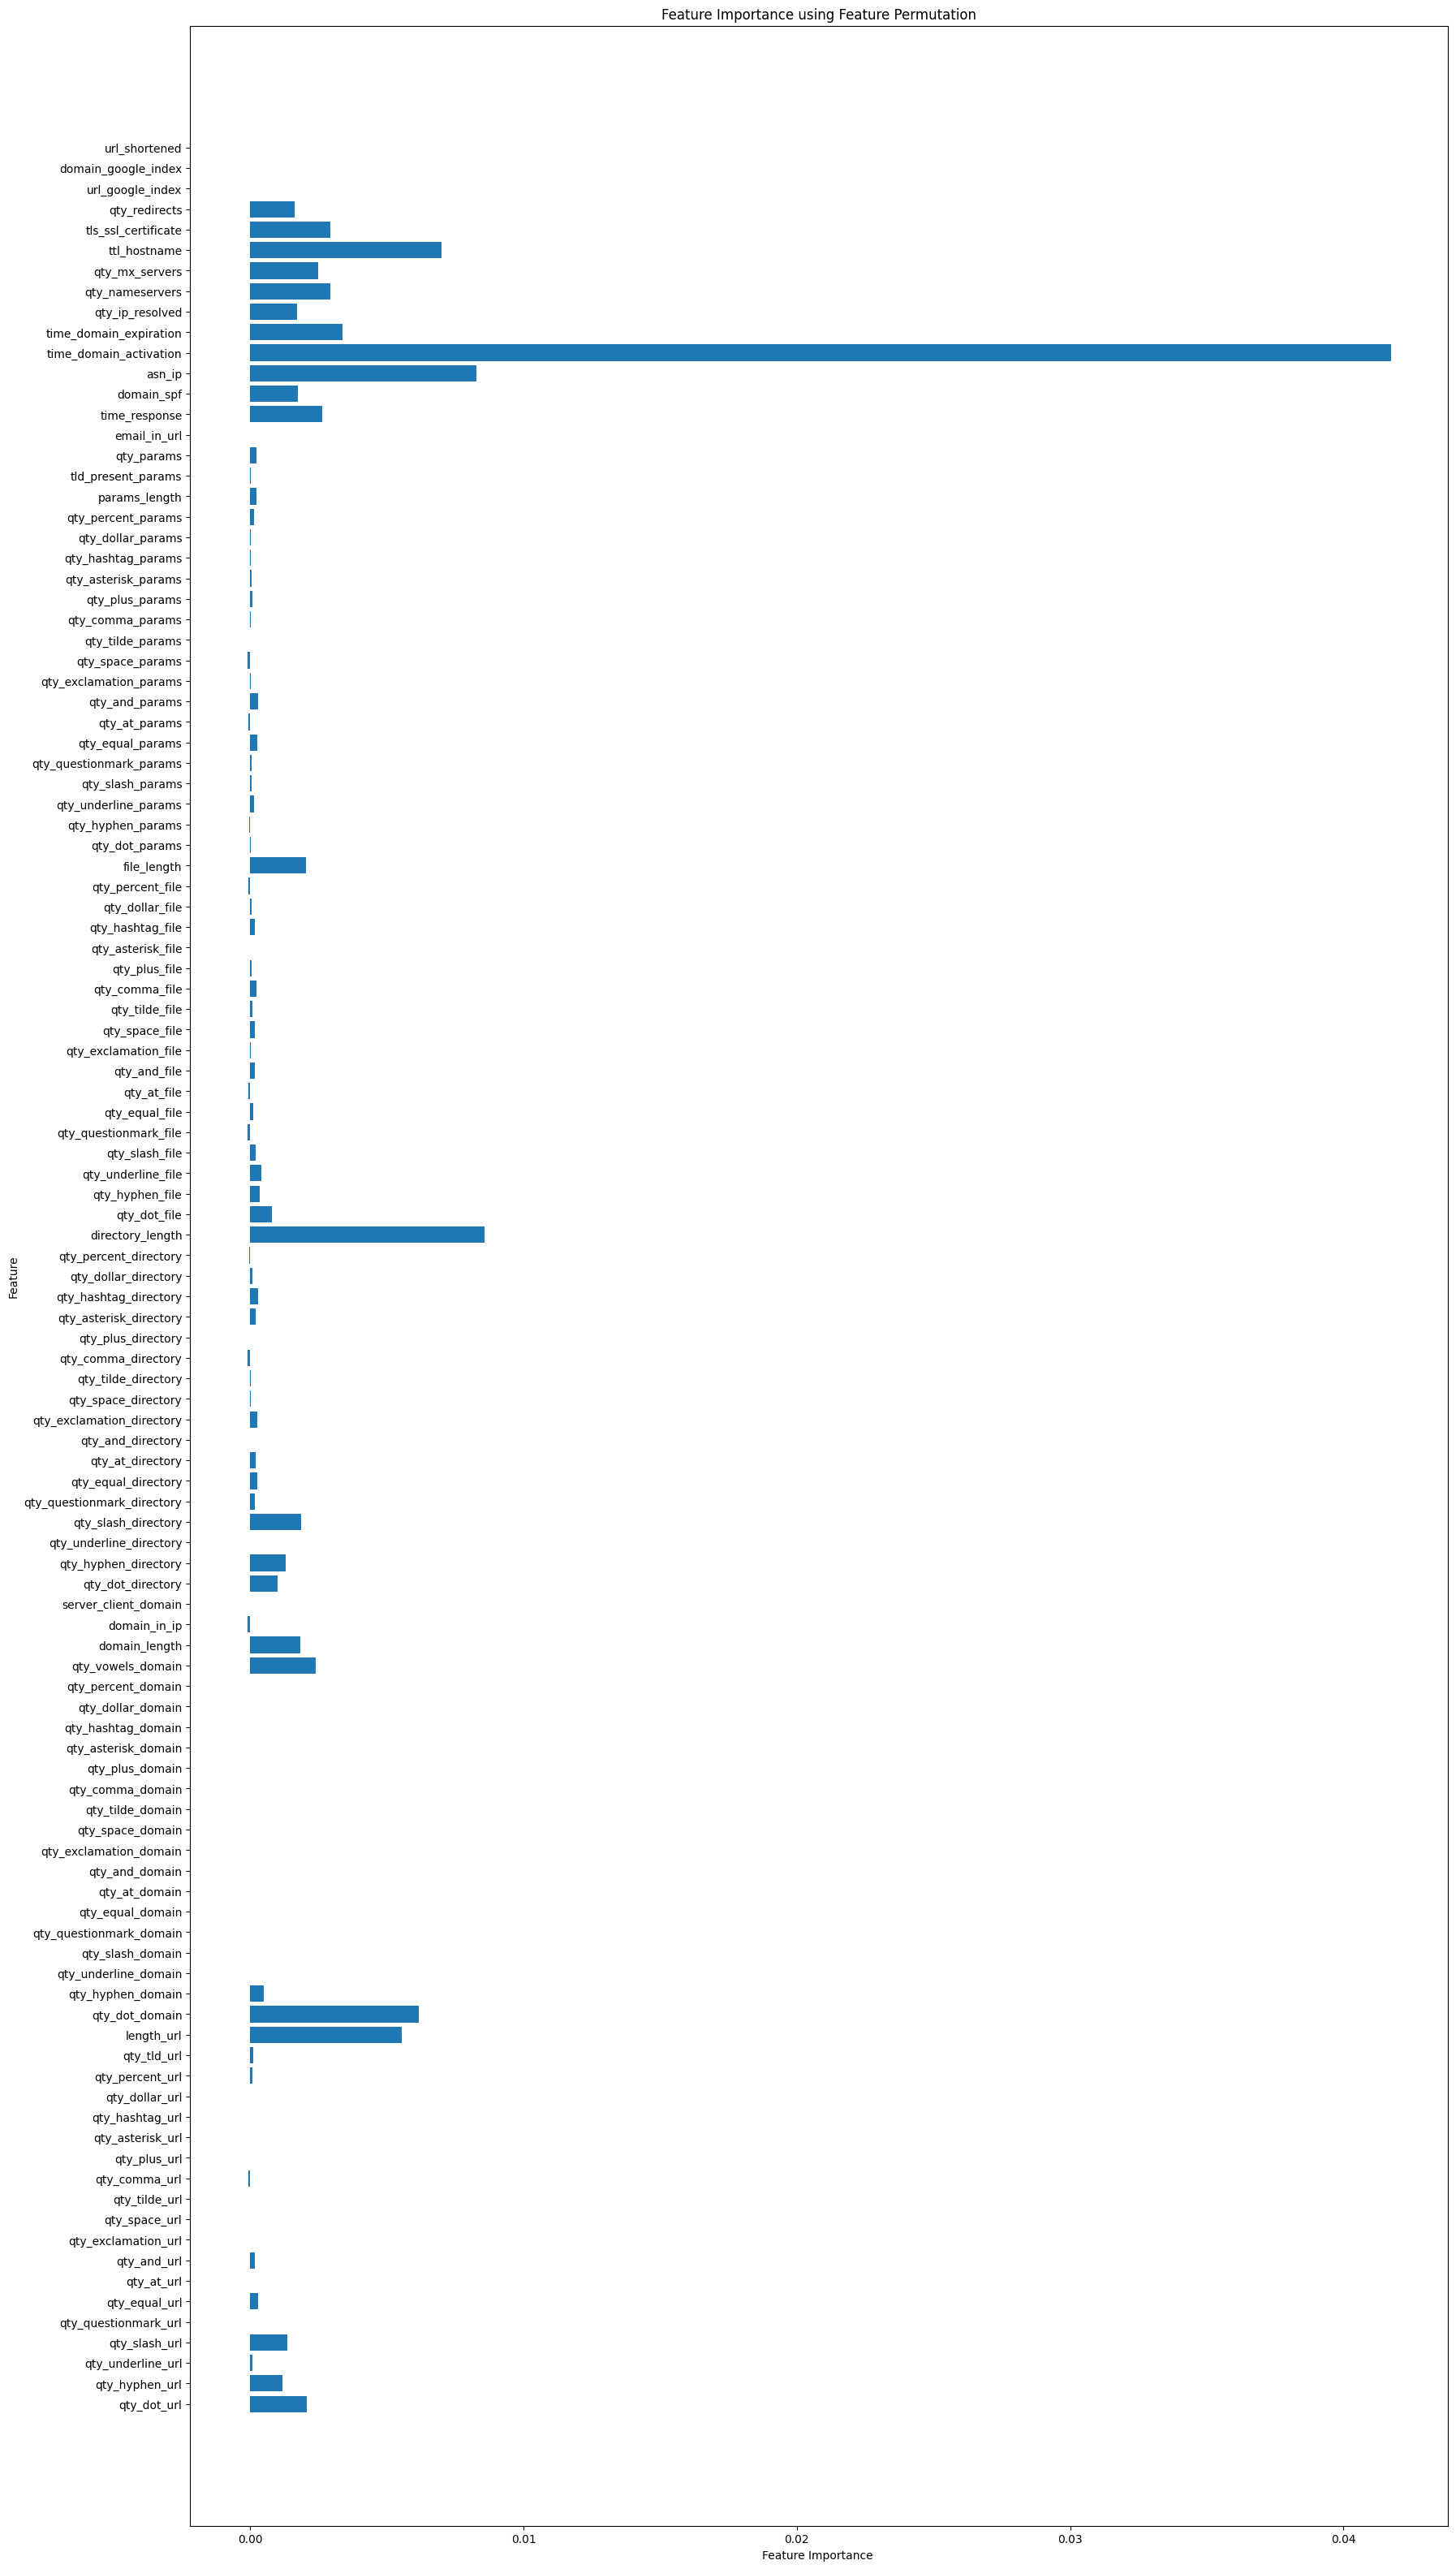

In [212]:
#plot the values with associated feature names
plt.figure(figsize=(20,40))
plt.barh(range(X.shape[1]), importances, align='center')
plt.yticks(range(X.shape[1]), feature_names)
plt.title('Feature Importance using Feature Permutation')
plt.xlabel('Feature Importance ')
plt.ylabel('Feature')
plt.show()

##**Neural Network Implementation**


In [223]:
"""The code in laboratory 4 and 5 was used as the starting point for the code below here (as a means to understand the PyTorch training loop. Further adjustements were 
a process of trial and error based on personal research"""

#for plotting purposes
training_accuracy, test_accuracy

#dataset for convenience when using DataLoader
train_dataset = TensorDataset(X_train_torch, y_train_torch)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#network architecture
model = nn.Sequential(
    nn.Linear(111, 512),
    nn.ReLU(),
    nn.Linear(512, 384),
    nn.ReLU(),
    nn.Linear(384, 256),
    nn.ReLU(),
    nn.Linear(256, 192),
    nn.ReLU(),
    nn.Linear(192, 128),
    nn.ReLU(),
    nn.Linear(128, 96),
    nn.ReLU(),
    nn.Linear(96, 64),
    nn.ReLU(),
    nn.Linear(64, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 2),
    nn.Sigmoid()
)

#optimizer and loss function with momentum and regularization (weight_decay)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.00005, momentum=0.87)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 50

#training loop with mini-batching
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0

    #minibatching
    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
    
    #epoch loss and accuracy
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, epoch_loss, epoch_acc*100))






SyntaxError: ignored

In [217]:
#TensorDataset for convenience when using DataLoader
train_dataset = TensorDataset(X_train_torch, y_train_torch)

#dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#training mode
model.train()

train_running_corrects = 0
train_running_total = 0

for train_inputs, train_labels in train_loader:
    train_outputs = model(train_inputs)
    train_labels = train_labels.view(-1)
    train_preds = torch.argmax(train_outputs, dim=1)
    train_running_corrects += torch.sum(train_preds == train_labels)
    train_running_total += train_labels.size(0)

#accuracy calculation
training_accuracy = (train_running_corrects.double() / train_running_total)*100
print('Training Accuracy: {:.2f}%'.format(training_accuracy))


Training Accuracy: 75.29%


In [218]:


#TensorDataset object for convenience when using DataLoader
test_dataset = TensorDataset(X_test_torch, y_test_torch)

#dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#avaluation mode
model.eval()

test_running_corrects = 0
test_running_total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_labels = test_labels.view(-1)
        test_preds = torch.argmax(test_outputs, dim=1)
        test_running_corrects += torch.sum(test_preds == test_labels)
        test_running_total += test_labels.size(0)

#accuracy calculation
test_accuracy = (test_running_corrects.double() / test_running_total)*100
print('Test Accuracy: {:.2f}%'.format(test_accuracy))

#for plotting purposes
nn_acc = [training_accuracy, test_accuracy]

Test Accuracy: 75.00%


#**Summary of Results**

###Model Performance

Overall, the training process as well as the feature importance analysis yieleded positive results; the models achieved good accuracy and the the feature importance calculations provided ample insight into the behavior of the tree-based models. 

In terms of accuracy, the Random Forest performed the best achieving ~97% accuracy. It is no surprise the Forest performed better than the Tree model, however the Neural Networks performance is more of a mystery having only achieved an accuracy of ~75%. This likely attributable to the implementation of the network, however it should be noted that Decision Trees and random forests seem to perform better with tabular data (like the dataset used in this project) than neural networks [4].

###Feature Importance 

Both MDI and feature permutation revealved interesting findings in regards to the importance of features during the classification process. 

It is clear that features pertaining to the websites specifics (hostname TTL, number of redirects, number of associated nameservers, etc.) along with the structure of the filename and its associated directory play the most important role in determining whether a URL is fraudulent or not. 

A Possible explanation of these findings is that scammers are likely going to try and provide a URL that is as similar as possible to the legitimate websites URL they are trying to masquerade as. Additionally, many legitmate websites have long directory structures in their URL for the sake of SEO and the likes. filenames that can execute code (i.e. *index.php?argName=...*) are likely to be used in malicious URLs. The importance of website specifics likely differ from that of legitimate websites as well. For example, the time between the domain is registered and its activation is extremely small in the case of websites used for phishing [5].  

##Accuracy Comparison

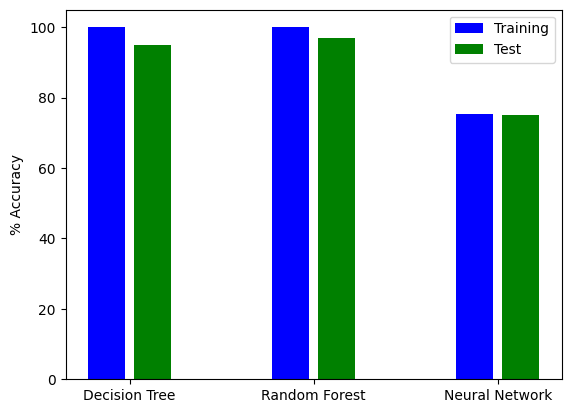

In [219]:
#plots the training and test accuracies in a grouped bar chart

# set the positions and width for the bars
positions = [1, 1.5, 3, 3.5, 5, 5.5]
width = 0.4

#bar plots for each group
plt.bar(positions[0], tree_acc[0], width=width, color='blue', label='Train')
plt.bar(positions[1], tree_acc[1], width=width, color='green', label='Test')

plt.bar(positions[2], forest_acc[0], width=width, color='blue')
plt.bar(positions[3], forest_acc[1], width=width, color='green')

plt.bar(positions[4], nn_acc[0], width=width, color='blue')
plt.bar(positions[5], nn_acc[1], width=width, color='green')

#figure info
plt.xticks([1.25, 3.25, 5.25], ['Decision Tree', 'Random Forest', 'Neural Network'])
plt.ylabel('% Accuracy')
plt.legend(['Training', 'Test'])

#display plot
plt.show()


##**Conclusion**

The challenge of identifying phishing websites is an interesting challenge, but is not without difficulties stemming from the complexity of the problem space. In the context of this project, the various models employed performed well with percentage accuracies in the high 90s. Also, there was success in uncovering model behaviour considering the decisiveness of the results related to feature importance. While datasets based on features extracted from URLs, it is clear based on previous papers written on the topic that more varied and continuously updated datasets are required to do so effectively as phishing techniques are only becoming more sophisticated.

#**References**

**[1]** Vrbančič, Grega (2020), “Phishing Websites Dataset”, Mendeley Data, V1, doi: 10.17632/72ptz43s9v.1

**[2]** "A novel Phishing classification based on URL features." IEEE Xplore. https://ieeexplore.ieee.org/abstract/document/5752505 (accessed Apr. 24, 2023).

**[3]** "Large-Scale Automatic Classification of Phishing Pages â Google Research." Google Research. https://research.google/pubs/pub35580/ (accessed Apr. 24, 2023).

**[4]** "Why do tree-based models still outperform deep learning on tabular data?" arXiv.org. https://arxiv.org/abs/2207.08815 (accessed Apr. 24, 2023).

**[5]** "Behind Phishing: An Examination of Phisher Modi Operandi." USENIX | The Advanced Computing Systems Association. https://www.usenix.org/legacy/events/leet08/tech/full_papers/mcgrath/mcgrath_html/mcgrath_gupta.html (accessed Apr. 24, 2023).

